In [12]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

from main import load_and_prepare_sessions
from processing.session_sampling import MiceAnalysis
from config import attr_interval_dict, all_metrics, all_brain_regions, all_event_types
from analysis.timepoint_analysis import sample_low_and_high_signals
from plotting.main_plotting import plot_signals
import matplotlib.pyplot as plt


sessions = load_and_prepare_sessions("../../../Baseline", load_from_pickle=True, remove_bad_signal_sessions=True)
mouse_analyser = MiceAnalysis(sessions)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from config import actions_attr_dict, reward_attr_dict
import numpy as np

In [14]:
def get_intervals_from_sessions_simple(sessions, actions_attr_dict, reward_attr_dict):
    """
    For each session, iterate over the filtered raw data (keeping only events of interest)
    and whenever a "Hit" event is found, look at the row immediately before (which must be "Display Image")
    and the row immediately after (which must be a valid reward event).
    
    Only includes a hit if the previous event is "Display Image" and the next event is a valid reward event.
    If a hit doesn't have an associated reward (e.g. at the end of the session), it is skipped.
    
    Prints warnings when a hit is skipped.
    
    Returns:
      Two lists aggregated across sessions:
        - disp_hit_intervals: time differences between the "Display Image" and the "Hit"
        - hit_reward_intervals: time differences between the "Hit" and the reward event
    """
    # Build the list of events of interest.
    events_of_interest = ['Display Image'] + list(actions_attr_dict.keys()) + list(reward_attr_dict.keys())
    
    disp_hit_intervals = []
    hit_reward_intervals = []
    
    for s_idx, session in enumerate(sessions):
        # Get the raw data for this session.
        raw_df = session.df_container.get_data("raw")[["Item_Name", "SecFromZero_FP3002"]]
        
        # Filter for events of interest and reset the index.
        filtered_df = raw_df[raw_df["Item_Name"].isin(events_of_interest)].reset_index(drop=True)
        
        # Loop over the rows, skipping the first and last rows.
        for i in range(1, len(filtered_df) - 1):
            if filtered_df.loc[i, "Item_Name"] == "Hit":
                prev_event = filtered_df.loc[i - 1, "Item_Name"]
                next_event = filtered_df.loc[i + 1, "Item_Name"]
                
                if prev_event != "Display Image":
                    print(f"Warning (session {s_idx}): Skipping Hit at filtered index {i}: previous event is '{prev_event}', expected 'Display Image'.")
                    continue
                
                if next_event not in reward_attr_dict.keys():
                    print(f"Warning (session {s_idx}): Skipping Hit at filtered index {i}: next event is '{next_event}', expected one of {list(reward_attr_dict.keys())}.")
                    continue
                
                disp_time = filtered_df.loc[i - 1, "SecFromZero_FP3002"]
                hit_time = filtered_df.loc[i, "SecFromZero_FP3002"]
                reward_time = filtered_df.loc[i + 1, "SecFromZero_FP3002"]
                disp_hit_intervals.append(hit_time - disp_time)
                hit_reward_intervals.append(reward_time - hit_time)
                    
    return disp_hit_intervals, hit_reward_intervals

# Example usage:
# disp_hit_intervals, hit_reward_intervals = get_intervals_from_sessions_simple(sessions, actions_attr_dict, reward_attr_dict)


In [ ]:
def get_avg_time_from_disp_to_hit_to_reward_raw(sessions):
    disp_to_hit_deltas = []
    hit_to_reward_deltas = []
    
    for session in sessions:
        event_idxs_data = session.event_idxs_container.data
        raw_df = session.df_container.get_data("raw")
        raw_times = raw_df['SecFromZero_FP3002'].values
        
        curr_dispimg_idxs = event_idxs_data['before_dispimg_hit']
        curr_hit_idxs = event_idxs_data['hit']
        curr_reward_idxs = event_idxs_data['reward_collect']

        min_len = min(len(curr_dispimg_idxs), len(curr_hit_idxs), len(curr_reward_idxs))
        curr_dispimg_idxs = curr_dispimg_idxs[:min_len]
        curr_hit_idxs = curr_hit_idxs[:min_len]
        curr_reward_idxs = curr_reward_idxs[:min_len]

        # Check index order for the current session
        if not ((np.array(curr_dispimg_idxs) < np.array(curr_hit_idxs)) & 
                (np.array(curr_hit_idxs) < np.array(curr_reward_idxs))).all():
            raise ValueError("Indices are not in order for a session")

        disp_to_hit_deltas.append(raw_times[curr_hit_idxs] - raw_times[curr_dispimg_idxs])
        hit_to_reward_deltas.append(raw_times[curr_reward_idxs] - raw_times[curr_hit_idxs])
    
    return disp_to_hit_deltas, hit_to_reward_deltas


In [ ]:
def get_avg_time_from_disp_to_hit_to_reward_phot(sessions):
    dispimg_idxs = []
    hit_idxs = []
    reward_idxs = []
    
    for session in sessions:
        event_idxs_data = session.event_idxs_container.data
        phot_df = session.df_container.get_data("photwrit_470")
        phot_times = phot_df['SecFromZero_FP3002'].values
        
        curr_dispimg_idxs = event_idxs_data['before_dispimg_hit']
        curr_hit_idxs = event_idxs_data['hit']
        curr_reward_idxs = event_idxs_data['reward_collect']

        min_len = min(len(curr_dispimg_idxs), len(curr_hit_idxs), len(curr_reward_idxs))

        curr_dispimg_idxs = curr_dispimg_idxs[:min_len]
        curr_hit_idxs = curr_hit_idxs[:min_len]
        curr_reward_idxs = curr_reward_idxs[:min_len]

        dispimg_idxs.extend(curr_dispimg_idxs)
        hit_idxs.extend(curr_hit_idxs)
        reward_idxs.extend(curr_reward_idxs)

    dispimg_idxs = np.array(dispimg_idxs)
    hit_idxs = np.array(hit_idxs)
    reward_idxs = np.array(reward_idxs)

    # Perform element-wise comparison
    if not ((dispimg_idxs < hit_idxs) & (hit_idxs < reward_idxs)).all():
        raise ValueError("Indices are not in order")

    return (phot_times[hit_idxs] - phot_times[dispimg_idxs],
            phot_times[reward_idxs] - phot_times[hit_idxs]) 

In [16]:
def compare_interval_methods(sessions, actions_attr_dict, reward_attr_dict):
    """
    Compares two methods of computing phot-based timing intervals:
    
      Method A: Using a simple one-row-before/after approach (get_intervals_from_sessions_simple)
      Method B: Using the event index container (get_avg_time_from_disp_to_hit_to_reward)
      
    Each method returns two sets of intervals:
      - Display-to-Hit intervals
      - Hit-to-Reward intervals
      
    The function flattens the lists (if needed), truncates them to equal length, then
    performs a linear regression (with Method B as independent variable and Method A as dependent)
    and computes the Pearson correlation coefficient.
    
    A slope near 1, intercept near 0, and high correlation indicate that the two methods are coupled.
    
    Returns a dictionary with the regression slope, intercept, and correlation for both interval types.
    """
    import numpy as np

    # Method A: Simple approach based on one-row-before/after.
    simple_disp_hit, simple_hit_reward = get_intervals_from_sessions_simple(sessions, actions_attr_dict, reward_attr_dict)
    simple_disp_hit = np.array(simple_disp_hit)
    simple_hit_reward = np.array(simple_hit_reward)

    # Method B: Container approach.
    container_disp_hit_list, container_hit_reward_list = get_avg_time_from_disp_to_hit_to_reward(sessions)
    # In the container approach, each session's intervals are appended as arrays; flatten them:
    container_disp_hit = np.concatenate(container_disp_hit_list) if container_disp_hit_list else np.array([])
    container_hit_reward = np.concatenate(container_hit_reward_list) if container_hit_reward_list else np.array([])

    # Truncate arrays to the same length for a fair comparison.
    min_len_disp = min(len(container_disp_hit), len(simple_disp_hit))
    min_len_hit = min(len(container_hit_reward), len(simple_hit_reward))
    
    container_disp_hit = container_disp_hit[:min_len_disp]
    simple_disp_hit = simple_disp_hit[:min_len_disp]
    
    container_hit_reward = container_hit_reward[:min_len_hit]
    simple_hit_reward = simple_hit_reward[:min_len_hit]
    
    # Perform linear regression: simple = slope * container + intercept
    slope_disp, intercept_disp = np.polyfit(container_disp_hit, simple_disp_hit, 1)
    slope_hit, intercept_hit = np.polyfit(container_hit_reward, simple_hit_reward, 1)
    
    # Compute Pearson correlation coefficients.
    corr_disp = np.corrcoef(container_disp_hit, simple_disp_hit)[0, 1]
    corr_hit = np.corrcoef(container_hit_reward, simple_hit_reward)[0, 1]
    
    # Print results.
    print("Comparison between phot timing interval methods:")
    print("Display-to-Hit intervals:")
    print("  Slope:", slope_disp)
    print("  Intercept:", intercept_disp)
    print("  Correlation:", corr_disp)
    print("")
    print("Hit-to-Reward intervals:")
    print("  Slope:", slope_hit)
    print("  Intercept:", intercept_hit)
    print("  Correlation:", corr_hit)
    
    return {
        "disp_hit": {"slope": slope_disp, "intercept": intercept_disp, "correlation": corr_disp},
        "hit_reward": {"slope": slope_hit, "intercept": intercept_hit, "correlation": corr_hit}
    }

# Example usage:
metrics = compare_interval_methods(sessions, actions_attr_dict, reward_attr_dict)
# If the slopes are near 1, intercepts near 0, and correlations high (close to 1), then the two methods are in strong agreement.


Comparison between phot timing interval methods:
Display-to-Hit intervals:
  Slope: 0.9999999999999997
  Intercept: 2.415886655950062e-17
  Correlation: 1.0

Hit-to-Reward intervals:
  Slope: 0.9999999999999996
  Intercept: 1.9438234614527373e-15
  Correlation: 0.9999999999999999


In [21]:
import numpy as np

def get_avg_time_from_disp_to_hit_to_reward_container_raw(sessions):
    disp_to_hit_deltas = []
    hit_to_reward_deltas = []
    
    for session in sessions:
        event_idxs_data = session.event_idxs_container.data
        raw_df = session.df_container.get_data("raw")
        raw_times = raw_df['SecFromZero_FP3002'].values.astype(float)
        
        curr_dispimg_idxs = event_idxs_data['before_dispimg_hit']
        curr_hit_idxs = event_idxs_data['hit']
        curr_reward_idxs = event_idxs_data['reward_collect']

        min_len = min(len(curr_dispimg_idxs), len(curr_hit_idxs), len(curr_reward_idxs))
        curr_dispimg_idxs = curr_dispimg_idxs[:min_len]
        curr_hit_idxs = curr_hit_idxs[:min_len]
        curr_reward_idxs = curr_reward_idxs[:min_len]

        # Check index order for the current session
        if not ((np.array(curr_dispimg_idxs) < np.array(curr_hit_idxs)) & 
                (np.array(curr_hit_idxs) < np.array(curr_reward_idxs))).all():
            raise ValueError("Indices are not in order for a session")
        
        # Compute the differences and append the resulting arrays.
        disp_to_hit_deltas.append(raw_times[curr_hit_idxs] - raw_times[curr_dispimg_idxs])
        hit_to_reward_deltas.append(raw_times[curr_reward_idxs] - raw_times[curr_hit_idxs])
    
    return disp_to_hit_deltas, hit_to_reward_deltas


def get_avg_time_from_disp_to_hit_to_reward_container_phot(sessions):
    """
    Container method using phot data.
    Aggregates intervals computed using event index container data with phot_df.
    Note: This method aggregates indices across sessions and then uses phot_times from the last session.
    """
    dispimg_idxs = []
    hit_idxs = []
    reward_idxs = []
    phot_times = None
    
    for session in sessions:
        event_idxs_data = session.event_idxs_container.data
        phot_df = session.df_container.get_data("photwrit_470")
        phot_times = phot_df['SecFromZero_FP3002'].values.astype(float)
        
        curr_dispimg_idxs = event_idxs_data['before_dispimg_hit']
        curr_hit_idxs = event_idxs_data['hit']
        curr_reward_idxs = event_idxs_data['reward_collect']

        min_len = min(len(curr_dispimg_idxs), len(curr_hit_idxs), len(curr_reward_idxs))
        curr_dispimg_idxs = curr_dispimg_idxs[:min_len]
        curr_hit_idxs = curr_hit_idxs[:min_len]
        curr_reward_idxs = curr_reward_idxs[:min_len]

        dispimg_idxs.extend(curr_dispimg_idxs)
        hit_idxs.extend(curr_hit_idxs)
        reward_idxs.extend(curr_reward_idxs)
    
    dispimg_idxs = np.array(dispimg_idxs, dtype=int)
    hit_idxs = np.array(hit_idxs, dtype=int)
    reward_idxs = np.array(reward_idxs, dtype=int)
    
    if not ((dispimg_idxs < hit_idxs) & (hit_idxs < reward_idxs)).all():
        raise ValueError("Indices are not in order for container phot method")
    
    return (phot_times[hit_idxs] - phot_times[dispimg_idxs],
            phot_times[reward_idxs] - phot_times[hit_idxs])


def get_intervals_from_sessions_simple(sessions, actions_attr_dict, reward_attr_dict):
    """
    For each session, iterate over the filtered raw data (keeping only events of interest)
    and whenever a "Hit" event is found, look at the row immediately before (which must be "Display Image")
    and the row immediately after (which must be a valid reward event).
    
    Only includes a hit if the previous event is "Display Image" and the next event is a valid reward event.
    If a hit doesn't have an associated reward (e.g. at the end of the session), it is skipped.
    
    Prints warnings when a hit is skipped.
    
    Returns:
      Two numpy arrays (of type float) aggregated across sessions:
        - disp_hit_intervals: time differences between the "Display Image" and the "Hit"
        - hit_reward_intervals: time differences between the "Hit" and the reward event
    """
    # Build the list of events of interest.
    events_of_interest = ['Display Image'] + list(actions_attr_dict.keys()) + list(reward_attr_dict.keys())
    
    disp_hit_intervals = []
    hit_reward_intervals = []
    
    for s_idx, session in enumerate(sessions):
        # Get the raw data for this session.
        raw_df = session.df_container.get_data("raw")[["Item_Name", "SecFromZero_FP3002"]]
        
        # Filter for events of interest and reset the index.
        filtered_df = raw_df[raw_df["Item_Name"].isin(events_of_interest)].reset_index(drop=True)
        
        # Loop over the rows, skipping the first and last rows.
        for i in range(1, len(filtered_df) - 1):
            if filtered_df.loc[i, "Item_Name"] == "Hit":
                prev_event = filtered_df.loc[i - 1, "Item_Name"]
                next_event = filtered_df.loc[i + 1, "Item_Name"]
                
                if prev_event != "Display Image":
                    print(f"Warning (session {s_idx}): Skipping Hit at filtered index {i}: previous event is '{prev_event}', expected 'Display Image'.")
                    continue
                
                if next_event not in reward_attr_dict.keys():
                    print(f"Warning (session {s_idx}): Skipping Hit at filtered index {i}: next event is '{next_event}', expected one of {list(reward_attr_dict.keys())}.")
                    continue
                
                disp_time = filtered_df.loc[i - 1, "SecFromZero_FP3002"]
                hit_time = filtered_df.loc[i, "SecFromZero_FP3002"]
                reward_time = filtered_df.loc[i + 1, "SecFromZero_FP3002"]
                disp_hit_intervals.append(hit_time - disp_time)
                hit_reward_intervals.append(reward_time - hit_time)
                    
    return np.array(disp_hit_intervals, dtype=float), np.array(hit_reward_intervals, dtype=float)


def compare_three_interval_methods(sessions, actions_attr_dict, reward_attr_dict):
    """
    Compares three methods for computing intervals:
      1. Container method using raw data (Container Raw)
      2. Container method using phot data (Container Phot)
      3. Simple one-row-before/after approach using raw data (Simple)
      
    For each method, two sets of intervals are computed:
      - Display-to-Hit intervals
      - Hit-to-Reward intervals
      
    The function performs pairwise comparisons (linear regression and Pearson correlation)
    between the three methods for each interval type. For each pair, we use one method's intervals
    as the independent variable and the other as the dependent variable. A slope near 1 and an intercept
    near 0 (with high correlation) indicate good agreement.
    
    This updated version ensures that if ContainerPhot is involved, it is always placed as the first method.
    
    Returns:
      A dictionary with the regression slope, intercept, and correlation for each pair and each interval type.
    """
    import numpy as np

    # Get intervals from the three methods.
    # Container using raw data:
    cont_raw_disp_list, cont_raw_hit_list = get_avg_time_from_disp_to_hit_to_reward_container_raw(sessions)
    cont_raw_disp = np.concatenate(cont_raw_disp_list).astype(float) if cont_raw_disp_list else np.array([], dtype=float)
    cont_raw_hit = np.concatenate(cont_raw_hit_list).astype(float) if cont_raw_hit_list else np.array([], dtype=float)
    
    # Container using phot data (already aggregated as one array):
    cont_phot_disp, cont_phot_hit = get_avg_time_from_disp_to_hit_to_reward_container_phot(sessions)
    cont_phot_disp = np.array(cont_phot_disp, dtype=float)
    cont_phot_hit = np.array(cont_phot_hit, dtype=float)
    
    # Simple approach using raw data:
    simple_disp, simple_hit = get_intervals_from_sessions_simple(sessions, actions_attr_dict, reward_attr_dict)
    simple_disp = np.array(simple_disp, dtype=float)
    simple_hit = np.array(simple_hit, dtype=float)
    
    # Define a helper to compute regression and correlation.
    def regression_stats(x, y):
        slope, intercept = np.polyfit(x, y, 1)
        corr = np.corrcoef(x, y)[0, 1]
        return slope, intercept, corr
    
    results = {}
    # Reorder comparisons so that if ContainerPhot is involved, it appears first.
    comparisons = [
        # Compare ContainerPhot vs ContainerRaw (ContainerPhot is first)
        ("ContainerPhot", cont_phot_disp, cont_phot_hit, "ContainerRaw", cont_raw_disp, cont_raw_hit),
        # Compare ContainerPhot vs Simple (ContainerPhot is first)
        ("ContainerPhot", cont_phot_disp, cont_phot_hit, "Simple", simple_disp, simple_hit),
        # For pairs not involving ContainerPhot, order remains as is.
        ("ContainerRaw", cont_raw_disp, cont_raw_hit, "Simple", simple_disp, simple_hit),
    ]
    
    for method1, disp1, hit1, method2, disp2, hit2 in comparisons:
        # Truncate to the same length.
        min_len_disp = min(len(disp1), len(disp2))
        min_len_hit = min(len(hit1), len(hit2))
        if min_len_disp == 0 or min_len_hit == 0:
            print(f"Warning: One of the comparisons ({method1} vs {method2}) has no data for regression.")
            continue
        x_disp = disp1[:min_len_disp]
        y_disp = disp2[:min_len_disp]
        x_hit = hit1[:min_len_hit]
        y_hit = hit2[:min_len_hit]
        
        slope_disp, intercept_disp, corr_disp = regression_stats(x_disp, y_disp)
        slope_hit, intercept_hit, corr_hit = regression_stats(x_hit, y_hit)
        
        key = f"{method1}_vs_{method2}"
        results[key] = {
            "disp_hit": {"slope": slope_disp, "intercept": intercept_disp, "correlation": corr_disp},
            "hit_reward": {"slope": slope_hit, "intercept": intercept_hit, "correlation": corr_hit}
        }
        
        print(f"Comparison: {key}")
        print("  Display-to-Hit:")
        print("    Slope:", slope_disp)
        print("    Intercept:", intercept_disp)
        print("    Correlation:", corr_disp)
        print("  Hit-to-Reward:")
        print("    Slope:", slope_hit)
        print("    Intercept:", intercept_hit)
        print("    Correlation:", corr_hit)
        print("")
    
    return results

# Example usage:
metrics = compare_three_interval_methods(sessions, actions_attr_dict, reward_attr_dict)
# This will print and return regression statistics for:
#   - ContainerPhot vs ContainerRaw
#   - ContainerPhot vs Simple
#   - ContainerRaw vs Simple


Comparison: ContainerPhot_vs_ContainerRaw
  Display-to-Hit:
    Slope: 3.189575372710598
    Intercept: -0.04225102719093121
    Correlation: 0.6629494097675167
  Hit-to-Reward:
    Slope: 27.7077861572512
    Intercept: -17.323923442835333
    Correlation: 0.901275210962175

Comparison: ContainerPhot_vs_Simple
  Display-to-Hit:
    Slope: 3.189575372710598
    Intercept: -0.04225102719093121
    Correlation: 0.6629494097675167
  Hit-to-Reward:
    Slope: 27.7077861572512
    Intercept: -17.323923442835333
    Correlation: 0.901275210962175

Comparison: ContainerRaw_vs_Simple
  Display-to-Hit:
    Slope: 0.9999999999999997
    Intercept: 2.415886655950062e-17
    Correlation: 1.0
  Hit-to-Reward:
    Slope: 0.9999999999999996
    Intercept: 1.9438234614527373e-15
    Correlation: 0.9999999999999999



lo sesh: 57
lo sesh: 57
lo sesh: 67
lo sesh: 67
lo sesh: 55
lo sesh: 55
hi sesh: 33
hi sesh: 33
hi sesh: 63
hi sesh: 63
hi sesh: 69


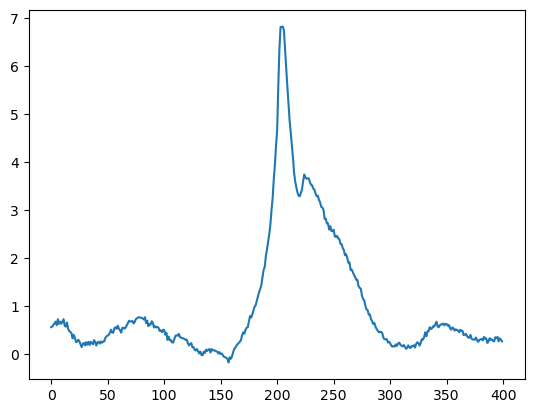

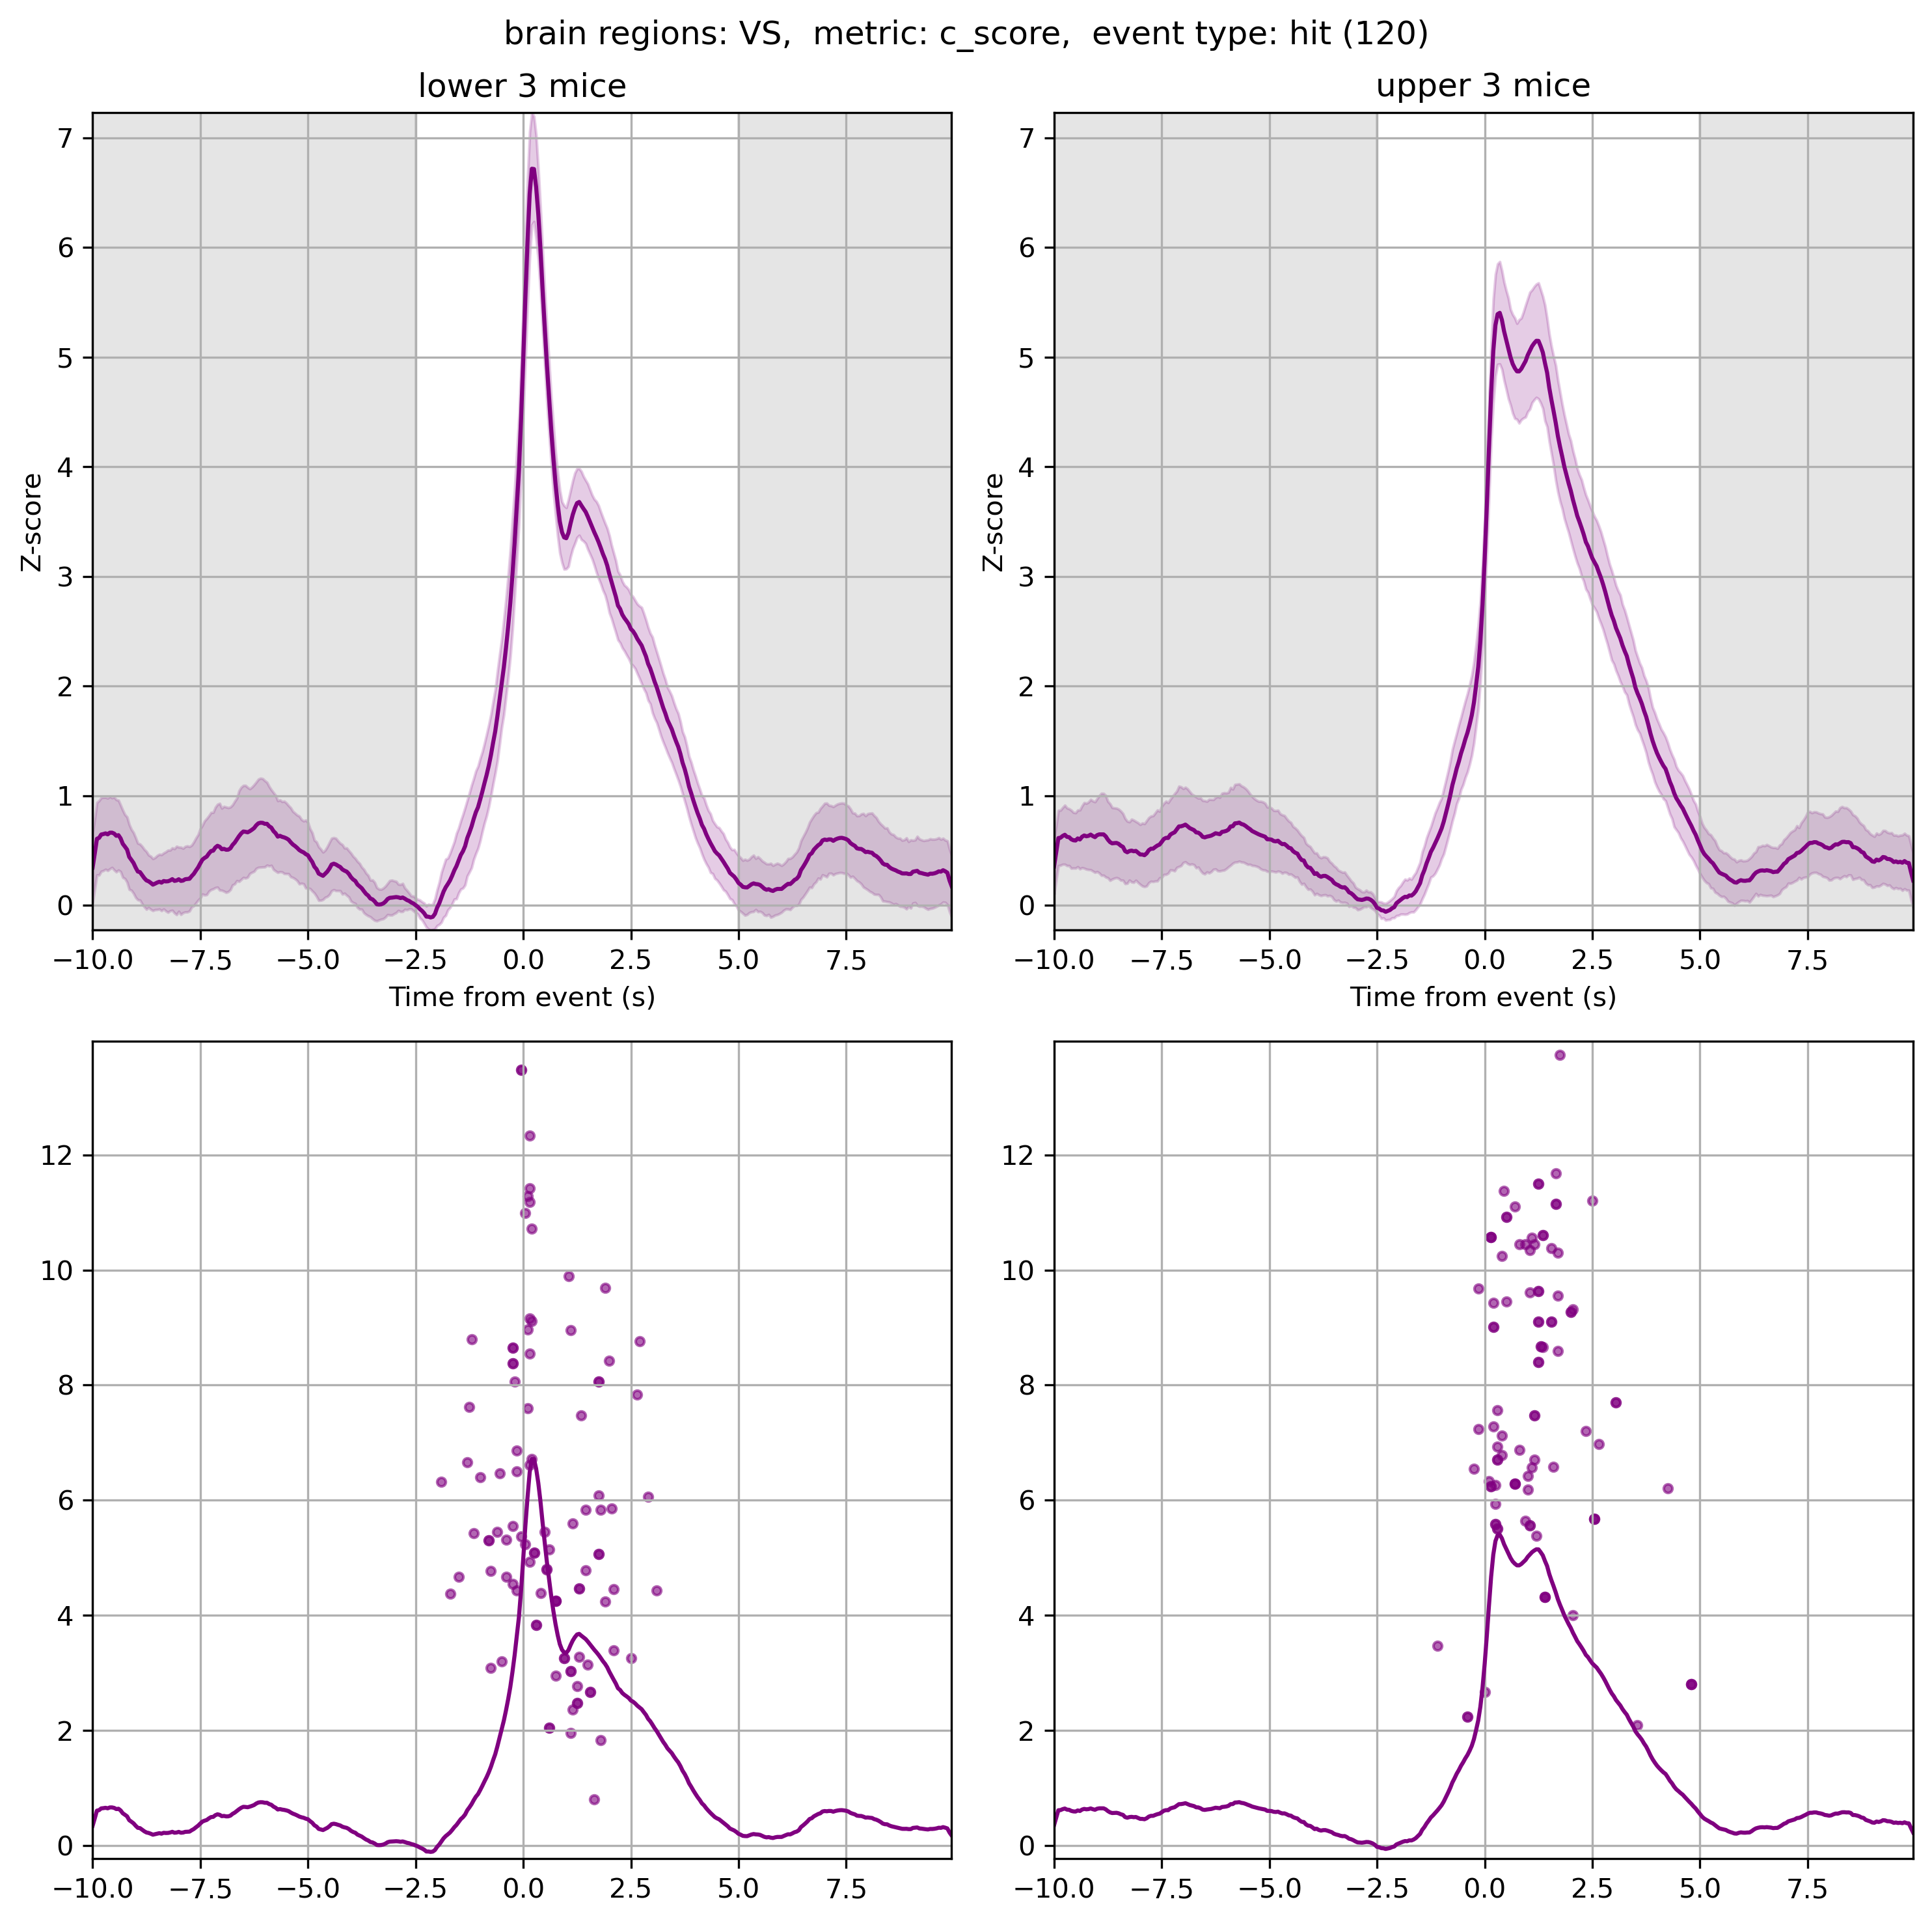

In [8]:
import itertools
import numpy as np
from scipy.stats import ttest_ind
from itertools import chain
from utils import mouse_br_events_count

# brain_reg_to_color = {'LH': 'orange',
#                       'mPFC': 'paleturquoise'}
brain_reg_to_color = {'VS': 'purple',
                      'DMS': 'forestgreen',
                      'DLS': 'C0'}

# Assuming config.all_metrics, config.all_brain_regions, and config.all_events are all iterable
for performance_metric, brain_region, event in itertools.product(all_metrics, all_brain_regions, all_event_types):
    low_signals, high_signals, low_resp_metrics, high_resp_metrics, resp_metric_names = \
        sample_low_and_high_signals('events', performance_metric, brain_region, event, mouse_analyser, n=1000)

    sb = attr_interval_dict[event]
    scatters = [np.zeros((2, 100)), np.zeros((2, 100))]
    resp_metric_infos = []
    is_significant_p_vals = []


    low_sample_idxs = np.random.choice(len(low_resp_metrics), size=100, replace=True)
    high_sample_idxs = np.random.choice(len(high_resp_metrics), size=100, replace=True)
    for col_idx, resp_metric_name in resp_metric_names.items():
        low_resp_metric = low_resp_metrics[:, col_idx]
        high_resp_metric = high_resp_metrics[:, col_idx]

        if resp_metric_name == 'peak_timing':
            scatters[0][0] = (low_resp_metric + attr_interval_dict[event][0])[low_sample_idxs]
            scatters[1][0] = (high_resp_metric + attr_interval_dict[event][0])[high_sample_idxs]
        elif resp_metric_name == 'maximal_value':
            scatters[0][1] = low_resp_metric[low_sample_idxs]
            scatters[1][1] = high_resp_metric[high_sample_idxs]

        t_stat, p_value = ttest_ind(low_resp_metric, high_resp_metric, nan_policy='omit')
        resp_metric_infos.append(f"            {resp_metric_name}: t-stat: {t_stat:.3f},  p-value: {p_value:.3e}")
        is_significant_p_vals.append(p_value <= 1/3000)
    #     if p_value > 1/3000:
    #         continue
    # if not any(is_significant_p_vals):
    #     continue

    suptitle = f"brain regions: {brain_region},  metric: {performance_metric},  event type: {event} ({low_signals.shape[0]})"#\nresponse metrics: "
    # for resp_metric_info in resp_metric_infos:
    #     suptitle += f"\n{resp_metric_info}"

    low_subtitle = f"lower 3 mice"
    high_subtitle = f"upper 3 mice"

    color = brain_reg_to_color[brain_region]
    plot_signals([low_signals, high_signals], [low_subtitle, high_subtitle], suptitle, color, 
                    5, sb, scatters=scatters)#, fname=f'{performance_metric}_{brain_region}_{event}.png')
             